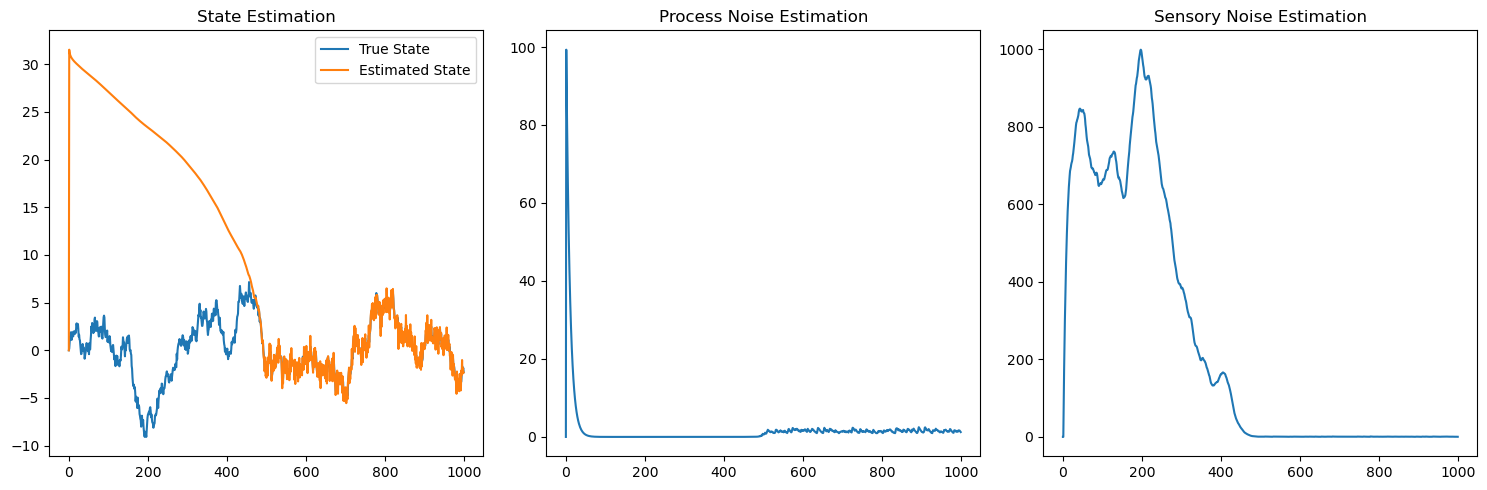

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Define the true dynamics and observations
T = 1000
x_true = np.zeros(T)
y_obs = np.zeros(T)

phi = 0.95

# Generate a true state with increasing process noise (AR(1) noise)
n_process = np.zeros(T)
for t in range(1, T):
    n_process[t] = np.random.randn()*0.5
    # n_process[t] = phi * n_process[t-1] + np.random.randn()
    x_true[t] = x_true[t-1] + n_process[t]

# Generate observations with a more pronounced periodic sensory noise (AR(1) noise)
n_sensory = np.zeros(T)
for t in range(T):
    n_sensory[t] =  np.random.randn() * 0.1
    #n_sensory[t] = 2*np.sin(t / 10) + phi * n_sensory[t-1] + np.random.randn() * 0.2
    y_obs[t] = x_true[t] + n_sensory[t]

# Initialize beliefs
x_belief = np.zeros(T)
process_noise_belief = np.zeros(T)
sensory_noise_belief = np.zeros(T)

alpha = 0.1  # Reduced learning rate

for t in range(1, T):
    # Prediction step
    x_predict = x_belief[t-1]
    prediction_error = y_obs[t] - x_predict
    
    # Update sensory noise belief
    sensory_noise_belief[t] = (1 - alpha) * sensory_noise_belief[t-1] + alpha * ((prediction_error)**2)
    
    # Update state belief using Kalman-like update
    x_belief[t] = x_predict +  prediction_error / sensory_noise_belief[t]  
    
    # Update process noise belief (using difference in beliefs)
    process_noise = (x_belief[t] - x_belief[t-1])**2
    # process_noise = (x_belief[t] - x_belief[t-1] - phi * n_process[t-1])**2
    process_noise_belief[t] = (1 - alpha) * process_noise_belief[t-1] + alpha * process_noise

# Plotting
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(x_true, label='True State')
plt.plot(x_belief, label='Estimated State')
plt.legend()
plt.title('State Estimation')

plt.subplot(1, 3, 2)
plt.plot(process_noise_belief, label='Estimated Process Noise')
plt.title('Process Noise Estimation')

plt.subplot(1, 3, 3)
plt.plot(sensory_noise_belief, label='Estimated Sensory Noise')
plt.title('Sensory Noise Estimation')

plt.tight_layout()
plt.show()

C:\Users\SIDTUDelft\AppData\Local\Temp\ipykernel_3856\3270813497.py:124: RuntimeWarning: divide by zero encountered in divide
  plt.plot(time, 1/alpha_process_belief)
C:\Users\SIDTUDelft\AppData\Local\Temp\ipykernel_3856\3270813497.py:130: RuntimeWarning: divide by zero encountered in divide
  plt.plot(time, 1/alpha_sensory_belief)


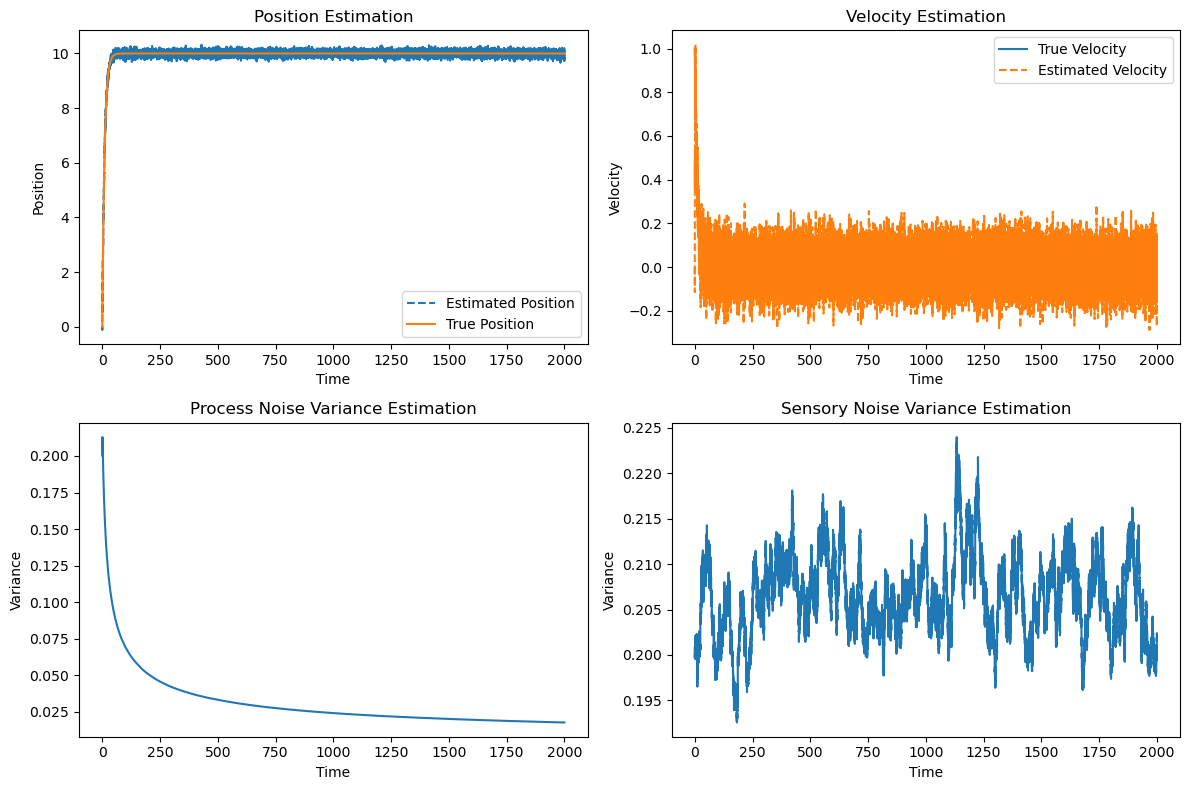

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define time settings
T = 2000
dt = 0.01
time = np.arange(0, T, dt)
decay = 0.999

# Generative process parameters
A_true = np.array([[1, dt],  # State dynamics
                   [0, decay]])  # Velocity dynamics

# Process noise
Q_true = np.array([[0, 0],
                   [0,   0 ]])

# Generate true states: position and velocity
x_gen = np.zeros((2, len(time)))
x_gen[:, 0] = [0, 1]  # Initial position and velocity

for t in range(1, len(time)):
    noise = np.random.multivariate_normal([0, 0], Q_true)
    x_gen[:, t] = np.dot(A_true, x_gen[:, t-1]) + noise

# Generate observations with sensory noise
H_true = np.array([1, 0])  # Observe position only
R_true = 0.2
y_obs = np.dot(H_true, x_gen) + np.sqrt(R_true) * np.random.randn(len(time))

# Generative model parameters
A = np.array([[1, dt],
              [0, 1]])
H = np.array([1, 0])

# Initial beliefs about states and uncertainties
mu = np.zeros((2, len(time)))
mu[:, 0] = [0, 0]
Sigma = np.array([[1, 0],
                  [0, 1]])

# Initial beliefs about process and sensory noise precisions (inverse variances)
alpha_process = 5  # Precision belief for process noise
alpha_sensory = 5  # Precision belief for sensory noise
learning_rate = 1

# Storage for estimated precisions (inverse variances)
alpha_process_belief = np.zeros(len(time))
alpha_sensory_belief = np.zeros(len(time))



mu_dot = 1
for t in range(1, len(time)):
    mu_prior = mu[:,t-1]
    
    mu_dot = decay*mu_dot
    mu_model = [mu_dot,0]              #velocity = 1

    D = np.array([[0,1], [0,0]])

    
    #e_x = mu[:, t-1] - mu[:, t-2]
    e_x = D.dot(mu_prior) - mu_dot 
    e_y = y_obs[t-1] - np.dot(H, mu_prior)

    dFdmu = -1*alpha_sensory*(e_y)
    dmu = np.dot(D,mu_prior) - 1*dFdmu
    mu[:,t] = mu[:,t-1] + dt*dmu


    alpha_process += learning_rate*dt*(1/alpha_process -e_x[0]**2)
    alpha_sensory += learning_rate*dt*(1/alpha_sensory -e_y**2)

    alpha_process_belief[t] = alpha_process
    alpha_sensory_belief[t] = alpha_sensory



# for t in range(1, len(time)):
    # Prediction
    # mu_prior = np.dot(A, mu[:, t-1])
    # Sigma_prior = np.dot(A, np.dot(Sigma, A.T)) + np.linalg.inv(np.array([[alpha_process, 0], [0, alpha_process]]))
    
    # # Update
    # prediction_error = y_obs[t] - np.dot(H, mu_prior)
    # Sigma_y = np.dot(H, np.dot(Sigma_prior, H.T)) + 1/alpha_sensory
    # Kalman_gain = np.dot(Sigma_prior, H.T) * (1/Sigma_y)
    # mu[:, t] = mu_prior + np.dot(Kalman_gain, prediction_error)
    # Sigma = Sigma_prior - np.dot(Kalman_gain, np.dot(H, Sigma_prior))
    
    # # Update beliefs about noise precisions using prediction error
    # # alpha_process += learning_rate * dt*(1/alpha_process - np.dot((mu[0, t] - mu_prior).T, (mu[0, t] - mu_prior)))
    # alpha_process += learning_rate * (np.dot((mu[:, t] - mu_prior).T, (mu[:, t] - mu_prior))-2)
    # # alpha_sensory += learning_rate * (-prediction_error**2 + 1/alpha_sensory)
    # alpha_sensory += learning_rate * (prediction_error**2 - 1/alpha_sensory)

    # # Store beliefs
    # alpha_process_belief[t] = alpha_process
    # alpha_sensory_belief[t] = alpha_sensory



plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)

plt.plot(time, mu[0, :], label='Estimated Position', linestyle='dashed')
plt.plot(time, x_gen[0, :], label='True Position')
plt.legend()
plt.title('Position Estimation')
plt.xlabel('Time')
plt.ylabel('Position')

plt.subplot(2, 2, 2)
plt.plot(time, x_gen[1, :], label='True Velocity')
plt.plot(time, mu[1, :], label='Estimated Velocity', linestyle='dashed')
plt.legend()
plt.title('Velocity Estimation')
plt.xlabel('Time')
plt.ylabel('Velocity')

plt.subplot(2, 2, 3)
plt.plot(time, 1/alpha_process_belief)
plt.title('Process Noise Variance Estimation')
plt.xlabel('Time')
plt.ylabel('Variance')

plt.subplot(2, 2, 4)
plt.plot(time, 1/alpha_sensory_belief)
plt.title('Sensory Noise Variance Estimation')
plt.xlabel('Time')
plt.ylabel('Variance')

plt.tight_layout()
plt.show()

0.01828483169470498
inf
inf


C:\Users\SIDTUDelft\AppData\Local\Temp\ipykernel_13572\1186195533.py:98: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/omega_y, label = "y")
C:\Users\SIDTUDelft\AppData\Local\Temp\ipykernel_13572\1186195533.py:99: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/omega_x, label = "x")
C:\Users\SIDTUDelft\AppData\Local\Temp\ipykernel_13572\1186195533.py:102: RuntimeWarning: divide by zero encountered in scalar divide
  print(1/omega_x[-1])
C:\Users\SIDTUDelft\AppData\Local\Temp\ipykernel_13572\1186195533.py:103: RuntimeWarning: divide by zero encountered in scalar divide
  print(1/omega_y[-1])


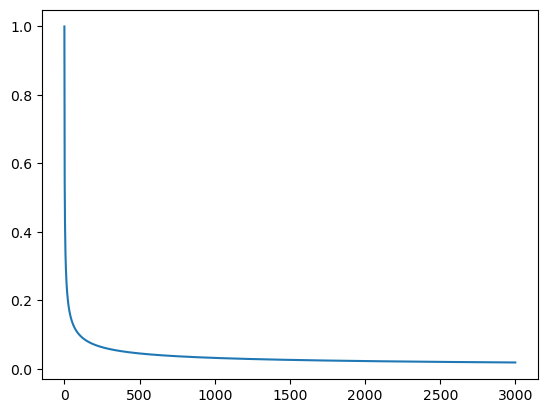

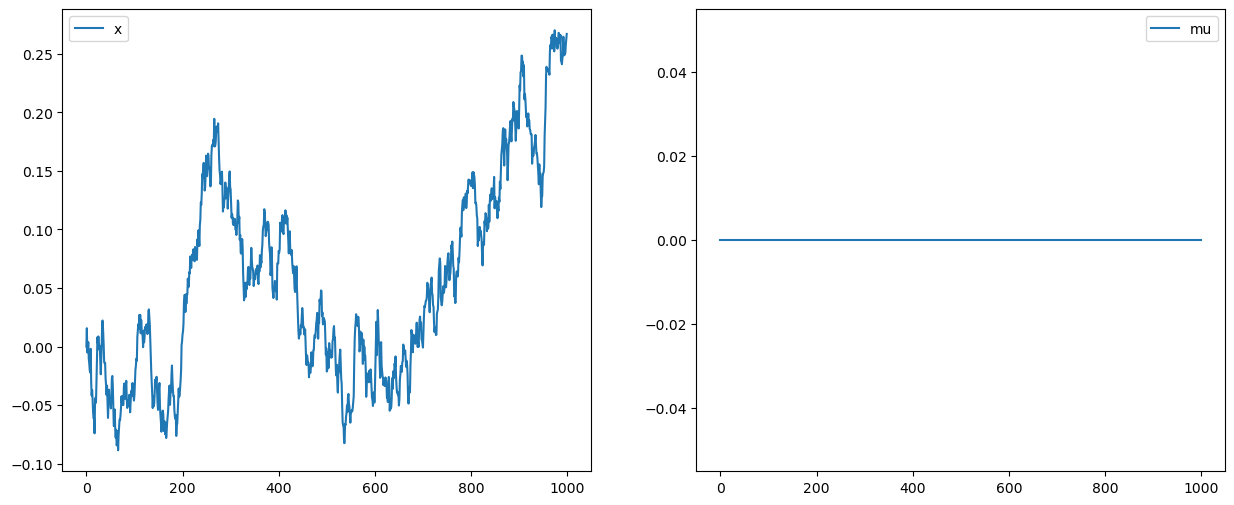

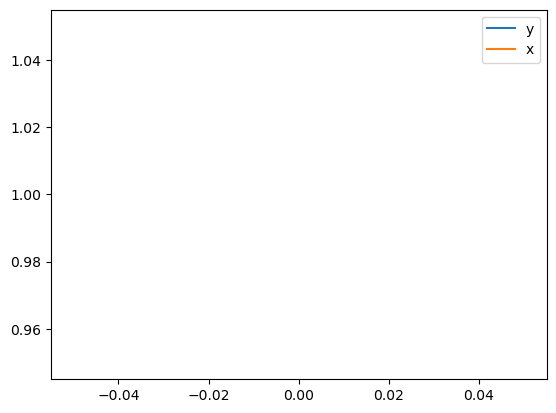

In [1]:
import numpy as np
import matplotlib.pyplot as plt

T = 300


y = np.zeros(T)
x = np.zeros(T)
e = np.zeros(T)
mu = np.zeros(T)

omega = np.zeros(T)
omega_x = np.zeros(T)
omega_y = np.zeros(T)
omega[0] = 1
omega_x[0] = 1
omega_y[0] = 1


alpha_mu = 1
alpha_x =  1
alpha_y =  1 



#generative process
for i in np.arange(0,T-1):
    x[i+1] = x[i]   + np.random.randn(1) * 0.01
    y[i]   = x[i]   #+ np.random.randn(1) * 0.5
    
    
    e = x[i] - x[i-1]
    domega= 0.5*(1/omega[i] - e**2)
    omega[i+1] = omega[i] +  alpha_x*domega

mu[0] = x[0]


for i in np.arange(0,T-1):
  
    #prediction errors 
    e_x = mu[i] - mu[i-1] 
    e_y = y[i] - mu[i]
    
    
    
    dFdmu = 1*omega_x[i]*e_x -1*omega_y[i]*e_y
    dmu   = 0 - alpha_mu* dFdmu
    mu[i+1] = mu[i] + 0.001*dmu
    
    domega_x = 0.5*(1/omega_x[i] - e_x**2)
    domega_y = 0.5*(1/omega_y[i] - e_y**2)
    omega_x[i+1] = omega_x[i] +  alpha_x*domega_x
    omega_y[i+1] = omega_y[i] +  alpha_y*domega_y



plt.figure()
plt.plot(1/omega)
print(1/omega[-1])


# plt.figure()
# plt.plot(y)



plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.plot(x[0:1000], label = "x")
plt.legend()

plt.subplot(1,2,2)
plt.plot(mu[0:1000], label = "mu")
plt.legend()


plt.figure()
plt.plot(1/omega_y, label = "y")
plt.plot(1/omega_x, label = "x")
plt.legend()

print(1/omega_x[-1])
print(1/omega_y[-1])

In [5]:
a = np.array([0],[1])
print(a)
b = np.array([0,1])
print(b)

TypeError: Field elements must be 2- or 3-tuples, got '1'

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define time settings
T = 100
dt = 0.01
time = np.arange(0, T, dt)
N  = time.size

x = np.zeros(N)
x_dot = np.zeros(N)
y = np.zeros(N)
y_dot = np.zeros(N)
mu = np.zeros(N)
mu_dot = np.zeros(N)
omega_w1 = np.zeros(N)
omega_w2 = np.zeros(N)
omega_z1 = np.zeros(N)
omega_z2 = np.zeros(N)


x[0] = 0
y[0] = 0
D = np.array([[0,1],[0,0]])
print(D)

for i in np.arange(0,N-1):

    x_dot[i] = 1   + np.random.randn(1)*0.1
    x[i+1] = x[i] + dt*x_dot[i]

    y[i] = x[i] + np.random.randn(1)*0.1
    y_dot[i] = x_dot[i] 
    



for i in np.arange(0,N-1):
    
    PI_w = np.diag([omega_w1[i],omega_w2[i]])
    PI_z = np.diag([omega_z1[i],omega_z2[i]])

    e_x = np.array([[mu_dot[i]], [0]]) - np.array([[1],[0]])
    e_y = np.array([[y[i]],[y_dot[i]]]) - np.array([[mu[i]],[mu_dot[i]]])
    

    dFdmu = np.array([[mu_dot[i]], [0]])    (-np.identity(2)*PI_z*e_x)

plt.figure()
plt.plot(x)


print(x)

[[0 1]
 [0 0]]


NameError: name 'PI_z' is not defined